In [1]:
import sys
from agents.agent import DDPG_Agent
from tasks.task import Task
from tasks.takeoff_task import TakeOffTask
from plotter import Plotter
import numpy as np

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Modify the values below to give the quadcopter a different starting position.
init_pose = np.array([0., 0., 100., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

num_episodes = 1000
target_pos = np.array([0., 0., 100.])
task = TakeOffTask(target_pos=target_pos)
agent = DDPG_Agent(task) 
avg_episode_rewards = []
episode_rewards = []

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done, is_learning = True)
        state = next_state
        if done:
            avg_episode_rewards.append(agent.score)
            episode_rewards.append(agent.total_reward)
            print("\rEpisode = {:4d}, avg_reward = {:7.3f}, reward = {:7.3f}".format(i_episode, agent.score, agent.total_reward), end="")
            break
    sys.stdout.flush()

Episode = 1000, avg_reward =   0.990, reward = 248.487

## Plot the Rewards

The plots shows total and avarage rewars per episode.

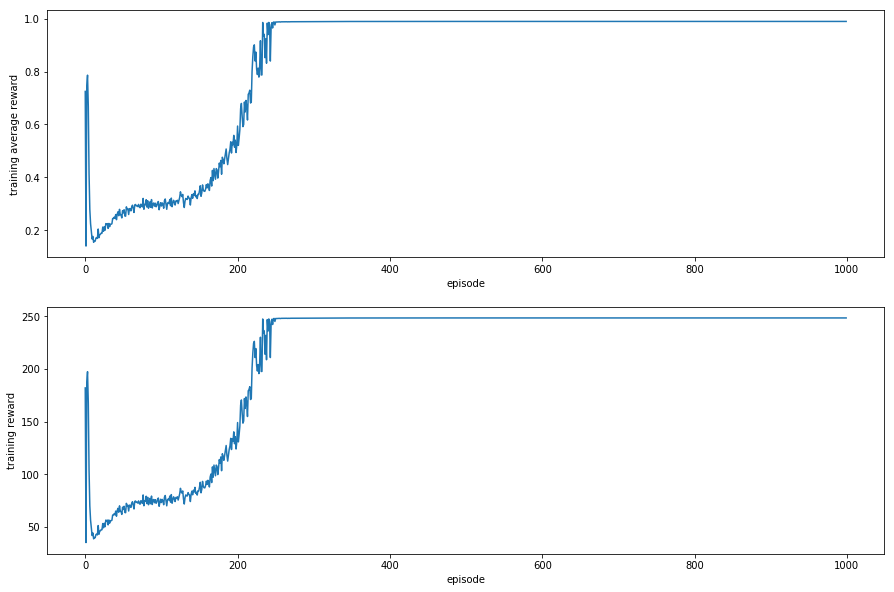

In [4]:
plt.subplots(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(avg_episode_rewards)
plt.xlabel('episode')
plt.ylabel('training average reward')

plt.subplot(2, 1, 2)
plt.plot(episode_rewards)
plt.xlabel('episode')
plt.ylabel('training reward')

plt.show()

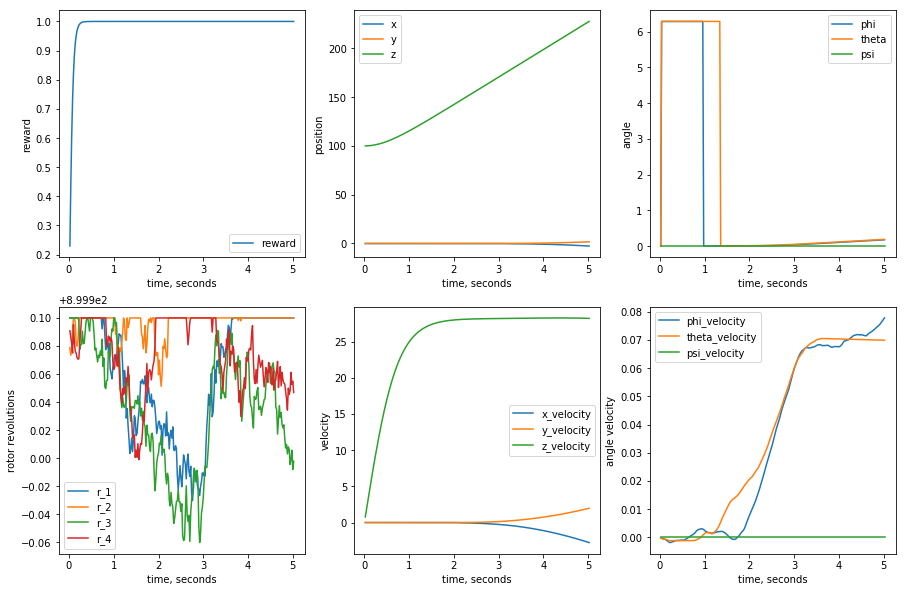

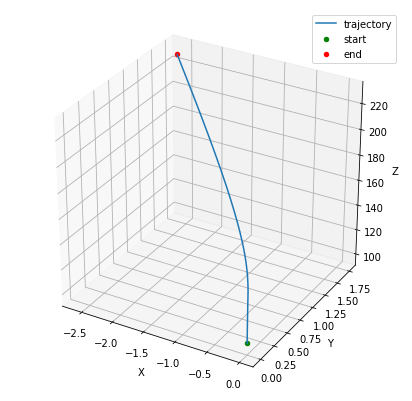

Start coordinates: x=  0.000 y=  0.000 z=100.008
End coordinates: x= -2.625 y=  1.752 z=227.568


In [15]:
state = agent.reset_episode() # start a new episode
plotter = Plotter()

while True:
    action = agent.act(state) 
    next_state, reward, done = task.step(action)
    
    # logging
    data_to_log = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward]
    plotter.add(data_to_log)
    
    agent.step(action, reward, next_state, done, is_learning=False)
    state = next_state
    if done:
        break
        
plotter.plot_all()
plotter.plot_trajectory()


## Reflections

### Question 1: Describe the task that you specified in task.py.  How did you design the reward function?

The task is to fly vertically upward. 

Initially I started with a complex reward function which contained several components. Namely, it endorsed the distance above the starting point across z-axis and positive vertical speed. Moreover, it penalized shifts across x and y directions, velocity in x and y directions and angle velocities. However, it turned out that it is very hard for an agent to learn such complex function because different components can compensate each other.

The next step was a simplification step where the reward function contained only two components: the distance between the starting and agent's position across z-axis and vertical speed. This reward function worked better but it was still sometimes misleading for the agent. Let's assume that at some point of time the distance between agent's position and starting point along z direction is -50 (means that agent moved down) and agent's vertical speed is +45. The final reward will be -5 but it actually should be positive because the agent actually moves upward. 

Taking into account all the above the final reward function takes into account only vertical speed. Z-velocity is scaled by a constant found empirically and squashed into the rage (-1,1) using tanh function which makes the process of neural network (NN) training better. Additionally, crushes are also penalized by giving the lowest possible reward of -1.


### Question 2: Discuss your agent briefly, using the following questions as a guide:

**- What learning algorithm(s) did you try? What worked best for you?**

I sticked to DDPG algorithm as it was recommended for the task and I wanted to look into the algorithm implementation details.

**- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)? What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.**

I have experimented with different neural network architectures. I started from the suggested architectures in the example code. Then I moved to the architecture suggested in the "Continuous control with deep reinforcement learning" paper. Finally, I landed somewhere in between. The actor's network has 3 fully connected (FC) layers with 64, 128 and 64 units respectively followed by a FC layer with unit number equals to action space. The critic network is bit more complicated as it has both state and action as an input. State input is fed into two FC layers with 64 and 128 units and action input is fed into one FC layer with 128 units. The next layer sums the two small NN together. The critic's final layer is a FC layer which has 1 unit and it outputs an estimated Q-value. Adam optimization algorithm was used with a learning rate of $10^{-7}$ and $10^{-5}$ for actor and critic respectively. The layers were initialized using Xavier initialization except the final layers. The final layers were initialized from a uniform distribution $[10^{-5}, 10^{5}]$ for actor and $[10^{-3}, 10^{3}]$ for critic. Both NNs used $L_2$ regularization with weight decay of $10^{-3}$. The discount factor $\gamma$ was chosen to be $0.99$ and for the soft update $\tau=0.01$ was used. The NNs were trained using minibatches of size $64$ and a replay buffer of size $10^4$. For exploration purposes an Ornstein-Uhlenbeck process with $\mu=0$, $\theta=0.01$ and $\sigma=0.01$ was used.

### Question 3: Using the episode rewards plot, discuss how the agent learned over time.

**- Was it an easy task to learn or hard?**

I think that the task is quite hard because it requires a large in magnitude action which should be balanced among all 4 rotors. The small adjustments might not have any affect till some point which makes training very difficult and very dependent on initial values. For example, if the actor's network outputs small values like 100 for all 4 rotors the quadcopter will move down and small updates of let's say 10 will not help until value becomes 500. In other words, the same action does not take any affect till some point which is extremely hard for a NN to figure out. If the updates are big then it is very difficult to stabilize the training.

**- Was there a gradual learning curve, or an aha moment?**

I have got a lot of different curves and some of them were stuck in a local minimum reporting the worst possible reward.  The one presented in the report is probably the best one I have got with the general gradual upward trend with some spikes on the way.

**- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)**

It only took agent 250 episodes to figure out the best possible strategy which can be seen in the rotor revolutions graph. The final strategy is to keep all the rotors at the maximum value of 900 with small fluctuations of 0.2 which is also the best possible strategy



### Question 4: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

** - What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)**

The hardest part for me was to find a way to make training work. I had a problem that the sigmoid function always blows up outputting either the smallest or the biggest value. I used several techniques for it:
* I used gradient clipping in the optimizers
* Experimented a lot with the learning rates and finally finding the ones that work.
* The most important one is to initialize the final layers with small values which makes sigmoid function work. With small initial values it is highly probable that the output of the sigmoid function will be around 0 which will be mapped in to the action value in the middle of the range (in my case it is 450) and it will be balanced across 4 rotors. However, it quadcopter might move down it is a very good start which makes training easier.

The other hard part was inconsistent and indirect training. From a lot of experiments I found out that the training process is highly dependent on the initialization and it might be difficult to repeat it. Unlike the traditional NN training where the loss function is directly influenced by the parameters, the reinforcement learning tasks have more moving parts and partially observable which makes it more difficult.

**- Did you find anything interesting in how the quadcopter or your agent behaved?**

A very interesting part was to define a reward function. As I mentioned above in the beginning I tried to combine a lot of components in the reward function. I found really interesting observing how agent changes its behavior depending on task definition and how difficult for agent to understand a complex reward function.